In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import json
import pickle


from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from xgboost import XGBRegressor

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline

# for Machine Learning Explainability
import eli5
from eli5.sklearn import PermutationImportance

from datetime import datetime

In [2]:
tr_Diesel = pd.read_csv('res_class_Table_main\\tr_Diesel.csv')
tr_Diesel.drop(['Unnamed: 0', 'Rotation'], axis=1, inplace=True)

tr_RME = pd.read_csv('res_class_Table_main\\tr_RME.csv')
tr_RME.drop(['Unnamed: 0', 'Rotation'], axis=1, inplace=True)

tr_Diesel_RME = pd.concat([tr_Diesel, tr_RME], ignore_index = True)
tr_Diesel_RME

,Ciś. pow. za turb.[Pa],ECT - wyjście z sil.[°C],MAF[kg/h],Moc[kW],Moment obrotowy[Nm],Obroty[obr/min],Temp. oleju w misce[°C],Temp. pal. na wyjściu sil.[°C],Temp. powietrza za turb.[°C],Zużycie paliwa średnie[g/s],...,HC,LAMBDA,CO2,O2,NO,PM,Сalorific value MJ/kg,Cetane number,Density at 15 °C,Viscosity at 40 °C
0,50768.0,52.099998,502.500000,73.152602,290.029745,2407.0,73.0,44.599998,64.0,4.8600,...,12.0,1.938,7.7,10.34,191.0,8.81,43.1,54.7,832.0,3.250
1,50768.0,52.099998,502.500000,73.053347,290.029745,2407.0,73.0,44.599998,64.0,4.8600,...,12.0,1.938,7.7,10.34,191.0,8.81,43.1,54.7,832.0,3.250
2,50768.0,52.099998,502.500000,73.053347,290.029745,2407.0,73.0,44.599998,64.0,4.8600,...,12.0,1.938,7.7,10.34,191.0,8.81,43.1,54.7,832.0,3.250
3,50768.0,52.099998,502.500000,73.053347,290.128978,2407.0,73.0,44.599998,64.0,4.8600,...,12.0,1.938,7.7,10.34,191.0,8.81,43.1,54.7,832.0,3.250
4,50768.0,52.099998,502.500000,73.053347,290.128978,2407.0,73.0,44.599998,64.0,4.8600,...,12.0,1.938,7.7,10.34,191.0,8.81,43.1,54.7,832.0,3.250
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44270,26173.0,74.500000,213.100006,48.071665,353.187679,1299.0,98.0,55.099998,61.0,3.1643,...,7.0,1.453,10.5,6.77,522.0,0.80,38.0,56.0,882.9,4.454
44271,26173.0,74.500000,213.100006,48.071665,353.187679,1299.0,98.0,55.099998,61.0,3.1643,...,7.0,1.453,10.5,6.77,522.0,0.80,38.0,56.0,882.9,4.454
44272,26173.0,74.500000,213.100006,48.071665,353.187679,1299.0,98.0,55.099998,61.0,3.1643,...,7.0,1.453,10.5,6.77,522.0,0.80,38.0,56.0,882.9,4.454
44273,26173.0,74.500000,213.100006,48.071665,353.187679,1299.0,98.0,55.099998,61.0,3.1643,...,7.0,1.453,10.5,6.77,522.0,0.80,38.0,56.0,882.9,4.454


In [3]:
tab3_for_artical = tr_Diesel_RME.loc[[0, 1, 20000, 44273, 44274], 
                  ['Zużycie paliwa średnie[g/s]', 'MAF[kg/h]', 'Obroty[obr/min]', 
                   'Temp. pal. na wyjściu sil.[°C]',
                   'Temp. powietrza za turb.[°C]',
                   'Сalorific value MJ/kg', 'Cetane number',
                   'Density at 15 °C', 'Viscosity at 40 °C ',
                     'PM', 'NO', 'CO', 'HC', 'CO2', 'Moment obrotowy[Nm]']]
tab3_for_artical.to_excel('res_class_Models\\tab3_for_artical_2.xlsx')

In [3]:
class Models:
    # unused targets 'CO', 'HC', 'LAMBDA', 'CO2', 'O2', 'NO', 'PM' 
    #target = []
    # unused features
    #features = ['Ciś. pow. za turb.[Pa]', 'ECT - wyjście z sil.[°C]', 'MAF[kg/h]',
    #           'Moc[kW]', 'Moment obrotowy[Nm]', 'Obroty[obr/min]',
    #           'Temp. oleju w misce[°C]', 'Temp. pal. na wyjściu sil.[°C]',
    #           'Temp. powietrza za turb.[°C]', 'Zużycie paliwa średnie[g/s]',
    #           'Temp. spalin 1...4/6 - srednia[°C]']
   
    def __init__(self, df=tr_Diesel_RME, res_name='test',target='PM', 
                features = ['Obroty[obr/min]','Zużycie paliwa średnie[g/s]', 
               'Сalorific value MJ/kg', 'Cetane number',
               'Density at 15 °C','Viscosity at 40 °C ']):
        
        self.res_name = res_name
        self.df = df
        self.features = features
        self.target = target
        #self.file_name = f'df_res_DT_{self.res_name}_target({self.target})' # use to save files, to describe the
        #self.y = self.df[self.target].values.ravel()
        self.y = self.df[self.target]
        #self.X = self.df[self.features].values
        self.X = self.df[self.features]
        self.dict_param = {'Calculated parameters and RMSE levels': np.nan,
                           ' -------------------------------------': '--------------------------',
                           'DecisionTree() - best parameters from GridSearchCV:': {np.nan},
                           'DT: model_DT_best': np.nan,  
                           'DT: RMSE_DT:': np.nan,
                           'DT: R2_DT:': np.nan,
                           'DT: Time GridSearchCV worked:': np.nan,
                           'DT: Seconds used for refitting the best model on the whole dataset:': np.nan,
                           'DT: permutation_importance:': np.nan,
                           ' --------------------------------------': '--------------------------',
                           'RandomForest() - best parameters from GridSearchCV:': {np.nan},
                           'RF: model_RF_best': np.nan,  
                           'RF: RMSE_RF:': np.nan,
                           'RF: R2_RF:': np.nan,
                           'RF: Time GridSearchCV worked:': np.nan,
                           'RF: Seconds used for refitting the best model on the whole dataset:': np.nan,
                           'RF: permutation_importance:': np.nan,
                           ' ---------------------------------------': '--------------------------',
                           'XGBoost() - best parameters from GridSearchCV:': {np.nan},
                           'XGB: model_XGB_best': np.nan,  
                           'XGB: RMSE_XGB:': np.nan,
                           'XGB: R2_XGB:': np.nan,
                           'XGB: Time GridSearchCV worked:': np.nan,
                           'XGB: Seconds used for refitting the best model on the whole dataset:': np.nan,
                           'XGB: permutation_importance:': np.nan,
                           ' ----------------------------------------': '--------------------------',
                           'DNN() - parameters': {np.nan}, 
                           'DNN: RMSE_DNN:': np.nan,
                           'DNN: R2_DNN:': np.nan,
                           'DNN: Seconds used for refitting the model on the whole dataset:': np.nan,
                          }
        
        #self.models = {'DT' : np.nan, 'RF' : np.nan, 'XGB' : np.nan, 'DNN' : np.nan}
        
        ### we use cros validation - train_test_split goes automaticaly
        ##### we need train_test_split for PermutationImportance --- Machine Learning Explainability
        self.train_X, self.val_X, self.train_y, self.val_y = train_test_split(self.X, self.y,
                                                                              random_state = 0)
        
        #self.DecisionTree()
        self.DecisionTree_only()
        
        #self.RandomForest()
        self.RandomForest_only()
        
        #self.XGBoost()
        #self.XGBoost_only()
        
        self.DNN()
        
        self.dict_param['Calculated parameters and RMSE levels'] = f'{self.res_name}_target({self.target})'        
        ## save self.dict_param (with all trained models) to pickle (serializer)
        self.dict_model_params = open(f"res_class_Models\dict_model_params_{self.res_name}_target({self.target}).pkl", 
                                      "wb")
        pickle.dump(self.dict_param, self.dict_model_params)
        self.dict_model_params.close()
        self.dict_model_params = open(f"res_class_Models\dict_model_params_{self.res_name}_target({self.target}).pkl", 
                                      "rb")
        self.output = pickle.load(self.dict_model_params)
        print(*[f'{key} - {val}' for key, val in self.output.items()], sep='\n', end='\n\n')
        self.dict_model_params.close()
        
        
    ''' !!!!!  DecisionTree   !!!!!!!'''    
    def DecisionTree(self):
        # 'min_samples_split': [10, 50, 100, 200, 300, 400, 1000, 2000, 3000],
        # 'max_leaf_nodes' : [10, 30, 40, 50, 60, 70, 100, 200, 300, 400, 1000],
        # 'max_depth' : [5, 10, 15, 20, 30, 50, 100, 200, 300, 400, 1000] 
        
        self.search_space_DT = {'min_samples_split': [10, 100, 400, 1000],
                                'max_leaf_nodes' : [10, 50, 100, 400],
                                'max_depth' : [5, 20, 50, 100, 400]
                                }
        ### start time
        self.datetime_DT_1 = datetime.now()
        self.model_DT = DecisionTreeRegressor(random_state=0)
        self.GS_DT = GridSearchCV(estimator = self.model_DT, 
                                  param_grid = self.search_space_DT,
                                  scoring = ['neg_mean_absolute_error',
                                             'neg_mean_squared_error',
                                             'neg_root_mean_squared_error', 
                                             'r2'],
                                  refit = 'r2',
                                  cv = 5, 
                                  verbose = 0)
        self.GS_DT.fit(self.X, self.y)        
        ### end time
        self.datetime_DT_2 = datetime.now()
        self.datetime_DT = self.datetime_DT_2 - self.datetime_DT_1
        
        ## results of GridSearchCV job
        self.model_DT_best = self.GS_DT.best_estimator_  #!!!!! model, that we can use to make predictions!
        self.dict_best_param_DT = self.GS_DT.best_params_
        self.R2_DT = self.GS_DT.best_score_
        self.time_DT = self.GS_DT.refit_time_
                       
        ## df with results of GridSearchCV job
        self.df_res_DT = pd.DataFrame(self.GS_DT.cv_results_)
        self.df_res_DT = self.df_res_DT.sort_values('rank_test_neg_root_mean_squared_error')
        self.df_res_DT.to_csv(f'res_class_Models\df_res_DT_{self.res_name}_target({self.target}).csv')
        
        self.permut_imp_DT = PermutationImportance(self.model_DT_best, random_state=1).fit(self.X, self.y)        
        self.df_permut_imp_DT = eli5.formatters.as_dataframe.explain_weights_df(self.permut_imp_DT,
                                                            self.df[self.features].columns.tolist()) 
    
        self.dict_param['DecisionTree() - best parameters from GridSearchCV:'] = self.dict_best_param_DT
        self.dict_param['DT: model_DT_best'] = self.model_DT_best
        #self.dict_param['DT: RMSE_DT:'] = self.MSE_DT
        self.dict_param['DT: R2_DT:'] = self.R2_DT
        self.dict_param['DT: Time GridSearchCV worked:'] = self.datetime_DT
        self.dict_param['DT: Seconds used for refitting the best model on the whole dataset:'] = self.time_DT
        self.dict_param['DT: permutation_importance:'] = self.df_permut_imp_DT

    ''' !!!!!  DecisionTree _ only  !!!!!!!'''    
    def DecisionTree_only(self):
        
        ### start time
        self.datetime_DT_1 = datetime.now()
        self.model_DT = DecisionTreeRegressor(max_depth=15, 
                                              max_leaf_nodes=30, 
                                              min_samples_split=400, 
                                              random_state=0)
        
        self.model_DT.fit(self.train_X, self.train_y)        
        ### end time
        self.datetime_DT_2 = datetime.now()
        self.datetime_DT = self.datetime_DT_2 - self.datetime_DT_1
        
        self.predicted_DT = self.model_DT.predict(self.val_X)
        self.R2_DT = r2_score(self.predicted_DT, self.val_y)
        self.MSE_DT = mean_squared_error(self.predicted_DT, self.val_y)

        
        ## results
        self.model_DT_best = self.model_DT  #!!!!! model, that we can use to make predictions!

        self.permut_imp_DT = PermutationImportance(self.model_DT, random_state=1).fit(self.val_X, self.val_y)        
        self.df_permut_imp_DT = eli5.formatters.as_dataframe.explain_weights_df(self.permut_imp_DT, 
                                                        feature_names = self.df[self.features].columns.tolist())
    
        #self.dict_param['DecisionTree() - best parameters from GridSearchCV:'] = self.dict_best_param_DT
        self.dict_param['DT: model_DT_best'] = self.model_DT
        self.dict_param['DT: RMSE_DT:'] = self.MSE_DT
        self.dict_param['DT: R2_DT:'] = self.R2_DT
        self.dict_param['DT: Time GridSearchCV worked:'] = self.datetime_DT
        #self.dict_param['DT: Seconds used for refitting the best model on the whole dataset:'] = self.time_DT
        self.dict_param['DT: permutation_importance:'] = self.df_permut_imp_DT
        
    ''' !!!!!  RandomForest   !!!!!!!'''    
    def RandomForest(self):
        # 'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600, 700, 1000]
        # 'max_depth' : [3, 4, 5, 6, 7, 8, 20, 50, 100] 
        
        self.search_space_RF = {'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600, 700, 1000],
                                'max_depth' : [3, 4, 5, 6, 7, 8, 20, 50, 100] 
                                }
        ### start time
        self.datetime_RF_1 = datetime.now()
        self.model_RF = RandomForestRegressor(random_state=0)
        self.GS_RF = GridSearchCV(estimator = self.model_RF, 
                                  param_grid = self.search_space_RF,
                                  scoring = ['neg_mean_absolute_error',
                                             'neg_mean_squared_error',
                                             'neg_root_mean_squared_error', 
                                             'r2'],
                                  refit = 'neg_root_mean_squared_error',
                                  cv = 5, 
                                  verbose = 0)
        self.GS_RF.fit(self.X, self.y)        
        ### end time
        self.datetime_RF_2 = datetime.now()
        self.datetime_RF = self.datetime_RF_2 - self.datetime_RF_1
        
        ## results of GridSearchCV job
        self.model_RF_best = self.GS_RF.best_estimator_  #!!!!! model, that we can use to make predictions!
        self.dict_best_param_RF = self.GS_RF.best_params_
        self.MSE_RF = self.GS_RF.best_score_
        self.time_RF = self.GS_RF.refit_time_
                       
        ## df with results of GridSearchCV job
        self.df_res_RF = pd.DataFrame(self.GS_RF.cv_results_)
        self.df_res_RF = self.df_res_RF.sort_values('rank_test_neg_root_mean_squared_error')
        self.df_res_RF.to_csv(f'res_class_Models\df_res_RF_{self.res_name}_target({self.target}).csv')
        
        self.permut_imp_RF = PermutationImportance(self.model_RF_best, random_state=1).fit(self.X, self.y)        
        self.df_permut_imp_RF = eli5.formatters.as_dataframe.explain_weights_df(self.permut_imp_RF, 
                                                        feature_names = self.df[self.features].columns.tolist())
        
        self.dict_param['RandomForest() - best parameters from GridSearchCV:'] = self.dict_best_param_RF
        self.dict_param['RF: model_RF_best'] = self.model_RF_best
        self.dict_param['RF: RMSE_RF:'] = self.MSE_RF
        self.dict_param['RF: Time GridSearchCV worked:'] = self.datetime_RF
        self.dict_param['RF: Seconds used for refitting the best model on the whole dataset:'] = self.time_RF
        self.dict_param['RF: permutation_importance:'] = self.df_permut_imp_RF
    
    ''' !!!!!  RandomForest _ only   !!!!!!!'''    
    def RandomForest_only(self):
        
        ### start time
        self.datetime_RF_1 = datetime.now()
        self.model_RF = RandomForestRegressor(n_estimators=10, 
                                              max_depth=7, 
                                             random_state=0)
        
        self.model_RF.fit(self.train_X, self.train_y)        
        ### end time
        self.datetime_RF_2 = datetime.now()
        self.datetime_RF = self.datetime_RF_2 - self.datetime_RF_1
        
        self.predicted_RF = self.model_RF.predict(self.val_X)
        self.R2_RF = r2_score(self.predicted_RF, self.val_y)
        self.MSE_RF = mean_squared_error(self.predicted_RF, self.val_y)

        
        ## results
        self.model_RF_best = self.model_RF  #!!!!! model, that we can use to make predictions!

        self.permut_imp_RF = PermutationImportance(self.model_RF, random_state=1).fit(self.val_X, self.val_y)        
        self.df_permut_imp_RF = eli5.formatters.as_dataframe.explain_weights_df(self.permut_imp_RF, 
                                                        feature_names = self.df[self.features].columns.tolist())
    
        #self.dict_param['DecisionTree() - best parameters from GridSearchCV:'] = self.dict_best_param_DT
        self.dict_param['RF: model_RF_best'] = self.model_RF
        self.dict_param['RF: RMSE_RF:'] = self.MSE_RF
        self.dict_param['RF: R2_RF:'] = self.R2_RF
        self.dict_param['RF: Time GridSearchCV worked:'] = self.datetime_RF
        #self.dict_param['DT: Seconds used for refitting the best model on the whole dataset:'] = self.time_DT
        self.dict_param['RF: permutation_importance:'] = self.df_permut_imp_RF
    
    
    ''' !!!!!  def XGBoost   !!!!!!!'''
    def XGBoost(self):
        # 'n_estimators': [10, 50, 100, 200, 300, 400, 500, 600, 700, 1000, 2000, 3000]
        # 'max_depth' : [3, 4, 5, 6, 7, 8, 20, 50, 100, 200]
        # 'learning_rate' : [0.001, 0.01, 0.05, 0.1, 1]
        
        self.search_space_XGB = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
                                 'max_depth' : [1, 2, 3, 4, 5, 6, 7, 8],
                                 'learning_rate' : [0.001,0.008, 0.01, 0.02, 0.03, 0.04]
                                }
        ### start time
        self.datetime_XGB_1 = datetime.now()
        self.model_XGB = XGBRegressor(random_state=0)
        self.GS_XGB = GridSearchCV(estimator = self.model_XGB, 
                                  param_grid = self.search_space_XGB,
                                  scoring = ['neg_mean_absolute_error',
                                             'neg_mean_squared_error',
                                             'neg_root_mean_squared_error', 
                                             'r2'],
                                  refit = 'r2',
                                  cv = 5, 
                                  verbose = 0)
        self.GS_XGB.fit(self.X, self.y)        
        ### end time
        self.datetime_XGB_2 = datetime.now()
        self.datetime_XGB = self.datetime_XGB_2 - self.datetime_XGB_1
        
        ## results of GridSearchCV job
        self.model_XGB_best = self.GS_XGB.best_estimator_  #!!!!! model, that we can use to make predictions!
        self.dict_best_param_XGB = self.GS_XGB.best_params_
        self.MSE_XGB = self.GS_XGB.best_score_
        self.time_XGB = self.GS_XGB.refit_time_
                       
        ## df with results of GridSearchCV job
        self.df_res_XGB = pd.DataFrame(self.GS_XGB.cv_results_)
        self.df_res_XGB = self.df_res_XGB.sort_values('rank_test_neg_root_mean_squared_error')
        self.df_res_XGB.to_csv(f'res_class_Models\df_res_XGB_{self.res_name}_target({self.target}).csv')
        
        self.permut_imp_XGB = PermutationImportance(self.model_XGB_best, random_state=1).fit(self.X, self.y)        
        self.df_permut_imp_XGB = eli5.formatters.as_dataframe.explain_weights_df(self.permut_imp_XGB, 
                                                        feature_names = self.df[self.features].columns.tolist())        
        
        self.dict_param['XGBoost() - best parameters from GridSearchCV:'] = self.dict_best_param_XGB
        self.dict_param['XGB: model_XGB_best'] = self.model_XGB_best
        self.dict_param['XGB: RMSE_XGB:'] = self.MSE_XGB
        self.dict_param['XGB: Time GridSearchCV worked:'] = self.datetime_XGB
        self.dict_param['XGB: Seconds used for refitting the best model on the whole dataset:'] = self.time_XGB
        self.dict_param['XGB: permutation_importance:'] = self.df_permut_imp_XGB

    ''' !!!!!  def XGBoost _ only   !!!!!!!'''
    def XGBoost_only(self):
        self.X1 = self.X.values 
        self.y1 = self.y.values.ravel()
        self.train_X1, self.val_X1, self.train_y1, self.val_y1 = train_test_split(self.X1, 
                                                                                  self.y1,
                                                                                  random_state = 0)
        ### start time
        self.datetime_XGB_1 = datetime.now()
        self.model_XGB = XGBRegressor(n_estimators=100, learning_rate=0.01, random_state=0)
        self.model_XGB.fit(self.train_X1, self.train_y1)        
        ### end time
        self.datetime_XGB_2 = datetime.now()
        self.datetime_XGB = self.datetime_XGB_2 - self.datetime_XGB_1
        
        self.predicted_XGB = self.model_XGB.predict(self.val_X1)
        self.R2_XGB = r2_score(self.predicted_XGB, self.val_y1)
        self.MSE_XGB = mean_squared_error(self.predicted_XGB, self.val_y1)

        ### end time
        self.datetime_XGB_2 = datetime.now()
        self.datetime_XGB = self.datetime_XGB_2 - self.datetime_XGB_1
               
        self.permut_imp_XGB = PermutationImportance(self.model_XGB, random_state=1).fit(self.X1, self.y1)        
        self.df_permut_imp_XGB = eli5.formatters.as_dataframe.explain_weights_df(self.permut_imp_XGB, 
                                                        feature_names = self.df[self.features].columns.tolist())        
        

        self.dict_param['XGB: RMSE_XGB:'] = self.MSE_XGB
        self.dict_param['r2: RMSE_XGB:'] = self.R2_XGB
        self.dict_param['XGB: Time GridSearchCV worked:'] = self.datetime_XGB
        self.dict_param['XGB: permutation_importance:'] = self.df_permut_imp_XGB
        
    
    ''' !!!!!  DNN   !!!!!!!'''
    def DNN(self):
        self.datetime_DNN_1 = datetime.now()

        self.early_stopping = callbacks.EarlyStopping(
                                            min_delta=0.001, # minimium amount of change to count as an improvement
                                            patience=20, # how many epochs to wait before stopping
                                            restore_best_weights=True)

        self.input_shape = [len(self.features)]
        self.output_shape = len(self.target)
        self.model_DNN = keras.Sequential([
                                            layers.Dense(50, activation='relu', input_shape=self.input_shape),
                                            #layers.Dropout(0.3),
                                            layers.Dense(50, activation='relu'),
                                            #layers.Dropout(0.3), 
                                            layers.Dense(50, activation='relu'),
                                            #layers.Dropout(0.3),
                                            layers.Dense(self.output_shape)
                                         ])

        self.model_DNN.compile(optimizer='adam', loss='mae')
        self.history_DNN = self.model_DNN.fit(self.train_X, self.train_y, 
                                            validation_data=(self.val_X, self.val_y), 
                                            batch_size=50, 
                                            epochs=500,
                                            callbacks=[self.early_stopping],
                                            verbose=0)
        ### end time
        self.datetime_DNN_2 = datetime.now()
        self.datetime_DNN = self.datetime_DNN_2 - self.datetime_DNN_1
        
        self.predicted_DNN = self.model_DNN.predict(self.val_X)
        self.MSE_DNN = mean_squared_error(self.predicted_DNN, self.val_y)
        self.R2_DNN = r2_score(self.predicted_DNN, self.val_y)

                        
        #self.dict_param['DNN() - parameters:'] = ..........
        self.dict_param['DNN: RMSE_DNN:'] = self.MSE_DNN
        self.dict_param['DNN: R2_DNN:'] = self.R2_DNN
        self.dict_param['DNN: Seconds used for refitting the model on the whole dataset:'] = self.datetime_DNN
        #self.dict_param['XGB: permutation_importance:'] = self.df_permut_imp_XGB
        
        
        # convert the training history to a dataframe
        self.history_df_DNN = pd.DataFrame(self.history_DNN.history)
        # use Pandas native plot method
        self.history_df_DNN['loss'].plot()
 

346/346 [==============================] - 0s 765us/step
Calculated parameters and RMSE levels - tr_Diesel_RME_23.09.2022_main_target(['PM', 'NO', 'CO', 'HC', 'CO2', 'Moment obrotowy[Nm]'])
 ------------------------------------- - --------------------------
DecisionTree() - best parameters from GridSearchCV: - {nan}
DT: model_DT_best - DecisionTreeRegressor(max_depth=15, max_leaf_nodes=30, min_samples_split=400,
                      random_state=0)
DT: RMSE_DT: - 0.014785242041666901
DT: R2_DT: - 0.9999669510312402
DT: Time GridSearchCV worked: - 0:00:00.086926
DT: Seconds used for refitting the best model on the whole dataset: - nan
DT: permutation_importance: -                           feature    weight       std
0     Zużycie paliwa średnie[g/s]  1.110178  0.002840
1                       MAF[kg/h]  0.312970  0.004870
2           Сalorific value MJ/kg  0.165546  0.000415
3  Temp. pal. na wyjściu sil.[°C]  0.139227  0.002109
4                Density at 15 °C  0.117703  0.003673
5  

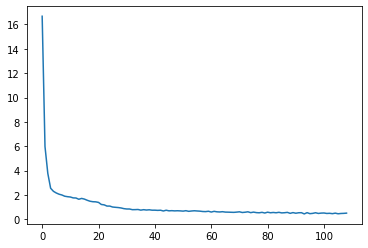

In [4]:
#features = ['Ciś. pow. za turb.[Pa]', 'ECT - wyjście z sil.[°C]', 'MAF[kg/h]',
#           'Moc[kW]', 'Moment obrotowy[Nm]', 'Obroty[obr/min]',
#           'Temp. oleju w misce[°C]', 'Temp. pal. na wyjściu sil.[°C]',
#           'Temp. powietrza za turb.[°C]', 'Zużycie paliwa średnie[g/s]',
#           'Temp. spalin 1...4/6 - srednia[°C]',
#           'Сalorific value MJ/kg', 'Cetane number',
#           'Density at 15 °C', 'Viscosity at 40 °C ']

# target = 'CO', 'HC', 'LAMBDA', 'CO2', 'O2', 'NO', 'PM', 

tr_Diesel_target_PM = Models(df=tr_Diesel_RME, 
                             res_name='tr_Diesel_RME_23.09.2022_main',
                             features=['Zużycie paliwa średnie[g/s]', 'MAF[kg/h]', 'Obroty[obr/min]', 
                                       'Temp. pal. na wyjściu sil.[°C]',
                                       'Temp. powietrza za turb.[°C]',
                                       'Сalorific value MJ/kg', 'Cetane number',
                                       'Density at 15 °C', 'Viscosity at 40 °C '],
                             target=['PM', 'NO', 'CO', 'HC', 'CO2', 'Moment obrotowy[Nm]'])

In [5]:
dict_model_params = open("res_class_Models\\dict_model_params_tr_Diesel_RME_23.09.2022_main_target(['PM', 'NO', 'CO', 'HC', 'CO2', 'Moment obrotowy[Nm]']).pkl", "rb")
output = pickle.load(dict_model_params)
print(*[f'{key} - {val}' for key, val in output.items()], sep='\n', end='\n\n')
dict_model_params.close()

Calculated parameters and RMSE levels - tr_Diesel_RME_23.09.2022_main_target(['PM', 'NO', 'CO', 'HC', 'CO2', 'Moment obrotowy[Nm]'])
 ------------------------------------- - --------------------------
DecisionTree() - best parameters from GridSearchCV: - {nan}
DT: model_DT_best - DecisionTreeRegressor(max_depth=15, max_leaf_nodes=30, min_samples_split=400,
                      random_state=0)
DT: RMSE_DT: - 0.014785242041666901
DT: R2_DT: - 0.9999669510312402
DT: Time GridSearchCV worked: - 0:00:00.086926
DT: Seconds used for refitting the best model on the whole dataset: - nan
DT: permutation_importance: -                           feature    weight       std
0     Zużycie paliwa średnie[g/s]  1.110178  0.002840
1                       MAF[kg/h]  0.312970  0.004870
2           Сalorific value MJ/kg  0.165546  0.000415
3  Temp. pal. na wyjściu sil.[°C]  0.139227  0.002109
4                Density at 15 °C  0.117703  0.003673
5                 Obroty[obr/min]  0.105843  0.000794
6     

In [6]:
dict_model_params = open("res_class_Models\\dict_model_params_tr_ON_RME_17.09.2022_main_target(NO).pkl", "rb")
output = pickle.load(dict_model_params)
print(*[f'{key} - {val}' for key, val in output.items()], sep='\n', end='\n\n')
dict_model_params.close()

Calculated parameters and RMSE levels - tr_ON_RME_17.09.2022_main_target(NO)
 ------------------------------------- - --------------------------
DecisionTree() - best parameters from GridSearchCV: - {'max_depth': 10, 'max_leaf_nodes': 30, 'min_samples_split': 10}
DT: model_DT_best - DecisionTreeRegressor(max_depth=10, max_leaf_nodes=30, min_samples_split=10,
                      random_state=0)
DT: RMSE_DT: - -47.07641822315262
DT: Time GridSearchCV worked: - 0:04:43.125796
DT: Seconds used for refitting the best model on the whole dataset: - 0.06249380111694336
DT: permutation_importance: -                                feature    weight           std
0          Zużycie paliwa średnie[g/s]  0.835640  4.668547e-03
1                            MAF[kg/h]  0.191291  5.702201e-04
2   Temp. spalin 1...4/6 - srednia[°C]  0.093033  2.289489e-04
3                      Obroty[obr/min]  0.026528  6.510392e-05
4                  Moment obrotowy[Nm]  0.012880  2.707320e-05
5                Сalor